<a href="https://colab.research.google.com/github/rdellavecchia/FaceSwap/blob/main/FaceSwap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepFake Video: Modifica i Volti con FaceSwap

## Configurazione dell'ambiente

In [1]:
!pip install torch torchvision mediapipe opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 15.6 MB/s eta 0:00:00


## Importazione delle librerie

In [21]:
import os
import cv2
import json
import mediapipe as mp
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

## Mediapipe (Soluzione 1)

### Configurazione del modello per la rilevazione dei landmarks

In [3]:
def get_keypoints_model(max_faces=5):
    """ Configurazione Mediapipe per rilevare fino a `max_faces` volti """
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=max_faces, refine_landmarks=True)

    def detect_keypoints_with_bboxes(image):
        """ Conversione dell'immagine in RGB """
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_image)

        faces_data = []  # Lista per salvare i dati di tutti i volti (keypoints + bbox)

        if results.multi_face_landmarks:
            h, w, _ = image.shape  # Dimensioni dell'immagine
            for face_landmarks in results.multi_face_landmarks:
                keypoints = []
                x_coords = []
                y_coords = []

                # Rilevazione dei keypoint
                for landmark in face_landmarks.landmark:
                    x = int(landmark.x * w)
                    y = int(landmark.y * h)
                    keypoints.append((x, y))
                    x_coords.append(x)
                    y_coords.append(y)

                # Calcolo del bounding box (rettangolo minimo che contiene i keypoint)
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                bbox = (x_min, y_min, x_max, y_max)

                # Salvataggio dei keypoint e del bounding box
                faces_data.append({"keypoints": keypoints, "bbox": bbox})
        return faces_data

    return detect_keypoints_with_bboxes

### Rappresentazione dei keypoints e del bounding box sull'immagine

In [4]:
def draw_faces(image, faces_data):
    """ Rappresentazione dei keypoints e dei bounding box sull'immagine. """
    for face_data in faces_data:
        # Disegna i keypoint
        for (x, y) in face_data["keypoints"]:
            cv2.circle(image, (x, y), 1, (0, 255, 0), -1)  # Cerchietti verdi

        # Disegna il bounding box
        x_min, y_min, x_max, y_max = face_data["bbox"]
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Rettangolo blu
    return image


### Test del modello e salvataggio delle immagini

In [5]:
if __name__ == "__main__":
    # Test del modello di keypoints con bounding box
    keypoint_model = get_keypoints_model(max_faces=5)

    # Percorso delle immagini di test
    test_images = ["/content/test.jpg", "/content/test1.jpg"]

    for img_path in test_images:
        image = cv2.imread(img_path)
        if image is not None:
            # Ottieni i dati dei volti (keypoints e bbox)
            faces_data = keypoint_model(image)

            # Disegna i risultati sull'immagine
            output_image = draw_faces(image, faces_data)

            # Salva e mostra l'immagine
            output_path = f"output_{img_path.split('/')[-1]}"
            cv2.imwrite(output_path, output_image)
            print(f"Immagine con keypoints e bounding box salvata in: {output_path}")

            # Stampa le informazioni
            print(f"Numero di volti rilevati in {img_path}: {len(faces_data)}")
            for i, face in enumerate(faces_data):
                print(f"Volto {i + 1}: Bounding Box: {face['bbox']}, Keypoints: {face['keypoints'][:5]} ...")  # Mostra solo i primi 5 keypoints
        else:
            print(f"Errore nel caricamento dell'immagine {img_path}")

Immagine con keypoints e bounding box salvata in: output_test.jpg
Numero di volti rilevati in /content/test.jpg: 1
Volto 1: Bounding Box: (317, 339, 605, 707), Keypoints: [(503, 588), (534, 559), (517, 568), (525, 510), (538, 545)] ...
Immagine con keypoints e bounding box salvata in: output_test1.jpg
Numero di volti rilevati in /content/test1.jpg: 2
Volto 1: Bounding Box: (735, 223, 1218, 813), Keypoints: [(948, 654), (965, 588), (962, 601), (958, 500), (968, 564)] ...
Volto 2: Bounding Box: (348, 650, 715, 1076), Keypoints: [(516, 901), (495, 844), (504, 864), (479, 802), (492, 828)] ...


## FFHQ

### Upload del file kaggle.json

In [7]:
from google.colab import files

# Richiesta di caricamento del file locale kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


### Creazione della directory ove si trova la configurazione di Kaggle

In [8]:
!mkdir -p ~/.kaggle

### Posizionamento del file kaggle.json nella directory creata

In [9]:
!cp kaggle.json ~/.kaggle/

### Modifica dei permessi del file per evitare errori

In [10]:
!chmod 600 ~/.kaggle/kaggle.json

### Download del dataset FFHQ da Kaggle

In [11]:
!kaggle datasets download -d arnaud58/flickrfaceshq-dataset-ffhq

Dataset URL: https://www.kaggle.com/datasets/arnaud58/flickrfaceshq-dataset-ffhq
License(s): CC-BY-SA-3.0
100% 19.5G/19.5G [04:30<00:00, 55.4MB/s]
100% 19.5G/19.5G [04:30<00:00, 77.3MB/s]


### Estrazione del contenuto scaricato

In [12]:
!unzip flickrfaceshq-dataset-ffhq.zip -d ./ffhq

Output streaming troncato alle ultime 5000 righe.
  inflating: ./ffhq/49001.png        
  inflating: ./ffhq/49002.png        
  inflating: ./ffhq/49003.png        
  inflating: ./ffhq/49004.png        
  inflating: ./ffhq/49005.png        
  inflating: ./ffhq/49006.png        
  inflating: ./ffhq/49007.png        
  inflating: ./ffhq/49008.png        
  inflating: ./ffhq/49009.png        
  inflating: ./ffhq/49010.png        
  inflating: ./ffhq/49011.png        
  inflating: ./ffhq/49012.png        
  inflating: ./ffhq/49013.png        
  inflating: ./ffhq/49014.png        
  inflating: ./ffhq/49015.png        
  inflating: ./ffhq/49016.png        
  inflating: ./ffhq/49017.png        
  inflating: ./ffhq/49018.png        
  inflating: ./ffhq/49019.png        
  inflating: ./ffhq/49020.png        
  inflating: ./ffhq/49021.png        
  inflating: ./ffhq/49022.png        
  inflating: ./ffhq/49023.png        
  inflating: ./ffhq/49024.png        
  inflating: ./ffhq/49025.png        


### Visualizzazione di alcuni example del dataset FFHQ

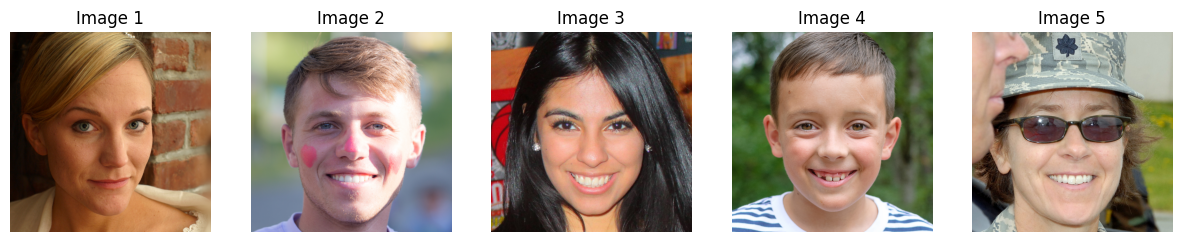

In [15]:
image_folder = "/content/ffhq"

# Scelta randomica di 5 immagini dalla cartella
image_files = os.listdir(image_folder)
random_images = random.sample(image_files, 5)

# Plot delle immagini selezionate randomicamente
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, image_file in enumerate(random_images):
    img = mpimg.imread(os.path.join(image_folder, image_file))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.show()

## FFHQ Annotato con i keypoint

### Creazione di un dataset annotato con keypoint e bounding box

In [40]:
def annotate_ffhq(ffhq_path, output_path, detect_keypoints_with_bboxes):
  """ Creazione di un dataset annotato con keypoint e bounding box per il dataset FFHQ """
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  annotations = []
  timings = []  # Lista per salvare i tempi di elaborazione

  for img_name in os.listdir(ffhq_path):
    img_path = os.path.join(ffhq_path, img_name)
    image = cv2.imread(img_path)

    if image is None:
      print(f"Immagine non valida: {img_name}")
      continue

    # Misurazione del tempo di elaborazione
    start_time = time.time()
    faces_data = detect_keypoints_with_bboxes(image) # Rilevazione di keypoints e bounding box
    elapsed_time = time.time() - start_time
    timings.append(elapsed_time)

    # Memorizzazione delle annotazioni per ogni volto
    for i, face_data in enumerate(faces_data):
      annotations.append({
        "image": img_name,
        "face_id": i,
        "keypoints": face_data["keypoints"],
        "bbox": face_data["bbox"]
      })

    # Memorizzazione delle immagini annotate
    annotated_image = draw_faces(image.copy(), faces_data)
    annotated_img_path = os.path.join(output_path, f"annotated_{img_name}")
    cv2.imwrite(annotated_img_path, annotated_image)

    # Memorizzazione delle annotazioni in un file JSON
    annotations_path = os.path.join(output_path, "annotations.json")
    with open(annotations_path, "w") as f:
      json.dump(annotations, f, indent=4)

    print(f"Annotazioni salvate in {annotations_path}")

    # Calcolo del tempo medio di elaborazione per ciascuna immagine
    avg_time = sum(timings) / len(timings) if timings else 0
    print(f"Tempo medio di elaborazione per immagine: {avg_time:.4f} secondi")

    return {
        "annotations": annotations,
        "timings": timings,
        "average_time": avg_time
    }

### Visualizzazione di alcuni example del dataset FFHQ annotato con plot delle misurazioni effettuate

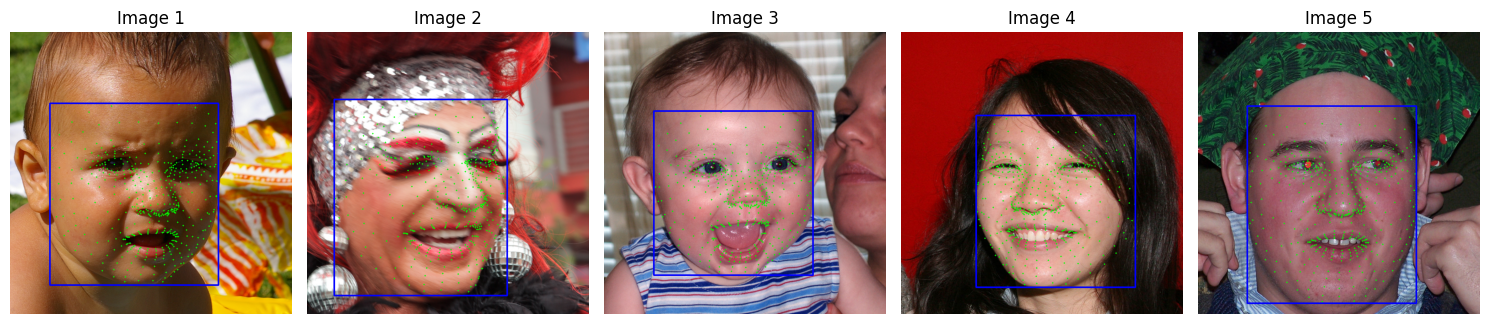

In [45]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def plot_annotated_images(image_folder, num_images=5):
    """ Scelta randomica di immagini, annotale e plot dei risultati """
    image_files = os.listdir(image_folder)
    random_images = random.sample(image_files, num_images)

    # Configurazione del modello Mediapipe
    detect_keypoints_with_bboxes = get_keypoints_model()

    # Calcolo del numero di righe necessarie
    num_rows = (num_images + 4) // 5

    # Configura la griglia con 5 colonne per riga
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 5))

    axes = axes.flatten() # axes deve essere un array monodimensionale

    for i, image_file in enumerate(random_images):
        img_path = os.path.join(image_folder, image_file)
        img = cv2.imread(img_path)

        if img is not None:
            # Rilevazione dei keypoint
            faces_data = detect_keypoints_with_bboxes(img)

            # Rappresentazione dei keypoint e del bounding box sull'immagine
            annotated_img = draw_faces(img.copy(), faces_data)

            # Conversione da BGR a RGB per il plotting
            annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

            # Plot dell'immagine annotata
            axes[i].imshow(annotated_img_rgb)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        else:
            print(f"Immagine non valida: {image_file}")
            axes[i].axis('off')
            axes[i].set_title("Invalid Image")

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
image_folder = "/content/ffhq"
plot_annotated_images(image_folder)